# Hadwritten Digit Recognition with Multi Layer Perceptron (MPL)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

from mnist import mlp
from utils import data, train

import numpy as np
import os

from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [3]:
batch_size=64

In [4]:
# Define data transformation
transform = transforms.Compose(
    [
        transforms.ToTensor(), # Transform image to torch.tensor
         transforms.Normalize((0.5,), (0.5,)) # Normalize
    ]
)

Now we can download the MNIST dataset and apply the transformation previosuly defined to all our training and test samples.

In [5]:
# Download train and test sets
train_set = datasets.MNIST(
    root="data/MNIST", train=True, download=True, transform=transform
)
test_set = datasets.MNIST(
    root="data/MNIST", train=False, download=True, transform=transform
)

# Check dataset size
assert len(train_set) == 60000
assert len(test_set) == 10000

In [6]:
train_loader, validation_loader = data.split_train_and_validation(train_set, batch_size)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

In [7]:
# Load a batch of train images (and labels)
train_iterator = iter(train_loader)
images, labels = train_iterator.next()
images = images.numpy()


# Check image size
assert images.shape == (batch_size, 1, 28, 28)

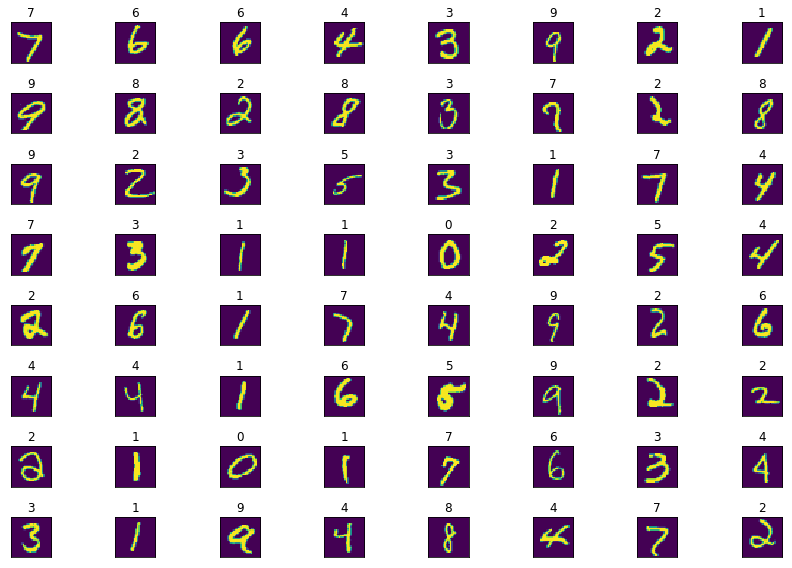

In [8]:
# Plot batch of train images
fig = plt.figure(figsize=(12,8))
for idx in range(batch_size):
    n = np.rint(np.sqrt(batch_size))
    ax = fig.add_subplot(n, n, idx + 1, xticks=[], yticks=[])
    plt.imshow((images[idx][0] + 0.5) * 0.5)  # Un-normalise
    ax.set_title(labels[idx].item(), fontdict={"fontsize": 12})
plt.tight_layout()
plt.show()

In [9]:
# Define the model
model = mlp.MLP((28 * 28, 512, 512, 10), 0.25)

# Move model to device
model = model.to(device)

In [10]:
# Set optimizer and bind to model
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [11]:
# Define loss
loss = nn.NLLLoss()

In [12]:
# Train model
epochs = 10
model_name = "data/MNIST/mlp_mnist.pt"
if os.path.isfile(model_name):
    # Load the model
    model.load_state_dict(torch.load(model_name))
else:
    train_loss, validation_loss = train.train(
        epochs,
        model,
        loss,
        optimizer,
        train_loader,
        validation_loader,
        model_name,
        device,
    )

    # Show train and validation losses
    fig = plt.figure()
    plt.plot(range(epochs), train_loss, label="Train Loss")
    plt.plot(range(epochs), validation_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

In [13]:
# Test the model
test_loss = 0.0
class_correct = list(range(10))
class_total = list(range(10))
model.eval()
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    predicted = model(data)
    l = loss(predicted, target)
    test_loss += l.item() * data.size(0)
    _, pred = torch.max(predicted, dim=1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
test_loss = test_loss / len(test_loader)
print(f"Test Loss: {test_loss:.6f}")
for i in range(10):
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        num_correct = np.sum(class_correct[i])
        num_total = np.sum(class_total[i])
        print(f"Test Accuracy of {i}: {accuracy:.2f}% ({num_correct}/{num_total})")
    else:
        print(f"Test Accuracy of {classes[i]}: N/A")

Test Loss: 10.189225
Test Accuracy of 0: 98.57% (966/980)
Test Accuracy of 1: 98.06% (1114/1136)
Test Accuracy of 2: 94.58% (978/1034)
Test Accuracy of 3: 95.56% (968/1013)
Test Accuracy of 4: 95.13% (938/986)
Test Accuracy of 5: 91.53% (821/897)
Test Accuracy of 6: 96.27% (928/964)
Test Accuracy of 7: 94.88% (982/1035)
Test Accuracy of 8: 94.70% (930/982)
Test Accuracy of 9: 92.73% (944/1018)


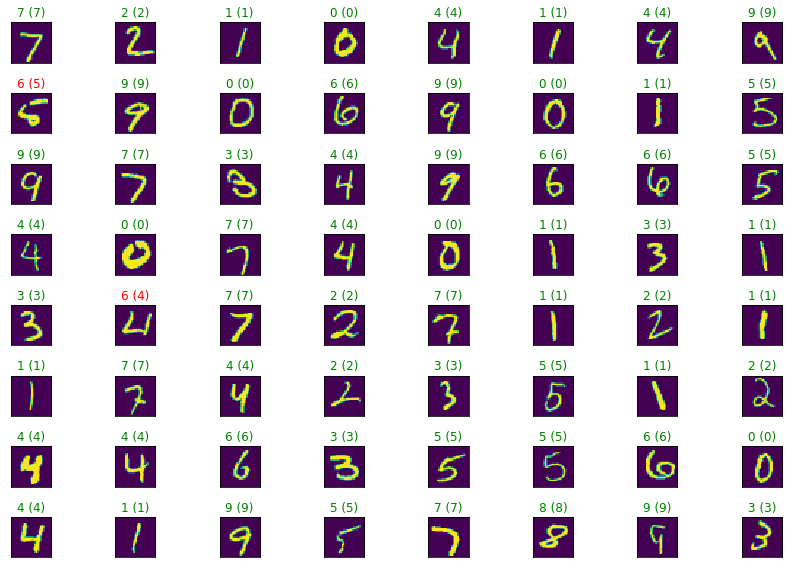

In [14]:
# Load a batch of test images (and labels) and compute predictions
model = model.to("cpu")
test_iterator = iter(test_loader)
images, labels = test_iterator.next()
predicted = model(images)
_, preds = torch.max(predicted, dim=1)
images = images.numpy()

# Plot batch of test images
fig = plt.figure(figsize=(12,8))
for idx in range(batch_size):
    n = np.rint(np.sqrt(batch_size))
    ax = fig.add_subplot(n, n, idx + 1, xticks=[], yticks=[])
    plt.imshow((images[idx][0] + 0.5) * 0.5)  # Un-normalise
    ax.set_title(
        f"{preds[idx].item()} ({labels[idx].item()})",
        fontdict={"fontsize": 12},
        color=("green" if preds[idx] == labels[idx] else "red"),
    )
plt.tight_layout()
plt.show()
